Install libraries

In [18]:
pip install pandas seaborn matplotlib scikit-learn numpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Step 1: Load Datasets
First, load your CSV files into pandas DataFrames.

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:


# Load the datasets
age_df = pd.read_csv('./data/california/homelessness-count-by-age.csv')
gender_df = pd.read_csv('./data/california/homelessness-count-by-gender.csv')
race_df = pd.read_csv('./data/california/homelessness-count-by-race.csv')
returns_df = pd.read_csv('./data/california/Strategic_Measure_Number_of_returns_to_homelessness.csv')

Step 2: Consolidate Datasets
Assuming CALENDAR_YEAR and LOCATION can serve as common keys among the first three datasets, and acknowledging that the fourth dataset has a different structure, let's focus on merging the first three for now.

In [12]:
# Assuming the structure allows for a direct merge; adjust based on actual dataset structure
# For illustration, let's merge on 'CALENDAR_YEAR' and 'LOCATION', assuming these fields are common and appropriately named
consolidated_df = pd.merge(age_df, gender_df, on=['CALENDAR_YEAR', 'LOCATION'], how='outer')
consolidated_df = pd.merge(consolidated_df, race_df, on=['CALENDAR_YEAR', 'LOCATION'], how='outer')

Step 3: Handle Missing Values

In [13]:
# Fill missing EXPERIENCING_HOMELESSNESS_CNT values with 0
consolidated_df['EXPERIENCING_HOMELESSNESS_CNT'].fillna(0, inplace=True)

/var/folders/tp/3wd6yzls5mn3qq9p_wh49y5r0000gn/T/ipykernel_31630/1443202328.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  consolidated_df['EXPERIENCING_HOMELESSNESS_CNT'].fillna(0, inplace=True)


Step 4: Normalize Text Fields

In [14]:
# Uppercase all LOCATION values
consolidated_df['LOCATION'] = consolidated_df['LOCATION'].str.upper()

# If there's a 'Demographic Category' or similar in returns_df, normalize it too
returns_df['Demographic Category'] = returns_df['Demographic Category'].str.upper()

Step 5: Date and Time Conversion
Assuming you decide to later incorporate Fiscal Year Start Date and Fiscal Year End Date from the returns_df for some time-based analysis.

In [15]:
# Convert to datetime format
returns_df['Fiscal Year Start Date'] = pd.to_datetime(returns_df['Fiscal Year Start Date'])
returns_df['Fiscal Year End Date'] = pd.to_datetime(returns_df['Fiscal Year End Date'])

/var/folders/tp/3wd6yzls5mn3qq9p_wh49y5r0000gn/T/ipykernel_31630/316475313.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  returns_df['Fiscal Year Start Date'] = pd.to_datetime(returns_df['Fiscal Year Start Date'])
/var/folders/tp/3wd6yzls5mn3qq9p_wh49y5r0000gn/T/ipykernel_31630/316475313.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  returns_df['Fiscal Year End Date'] = pd.to_datetime(returns_df['Fiscal Year End Date'])


Save m=new datasets

In [8]:
returns_df.to_csv(path_or_buf="./data/treated/treatedReturns.csv")
consolidated_df.to_csv(path_or_buf="./data/treated/consolidatedData.csv")

Feature Engineering
1. Create Age Group Flags

In [16]:
consolidated_df['AGE_GROUP_PUBLIC'].unique()

array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'Under 18',
       'Unknown'], dtype=object)

In [17]:
# Remove 'unknown' AGE_GROUP_PUBLIC
consolidated_df = consolidated_df[consolidated_df['AGE_GROUP_PUBLIC'] != 'unknown']

# Creating flags for Children, Adults, and Elders
consolidated_df['Children_Flag'] = consolidated_df['AGE_GROUP_PUBLIC'].apply(lambda x: 1 if x == 'Under 18' else 0)
consolidated_df['Adult_Flag'] = consolidated_df['AGE_GROUP_PUBLIC'].apply(lambda x: 1 if '24' in x or '34' in x or '44' in x or '54' in x or '64' in x else 0)
consolidated_df['Elder_Flag'] = consolidated_df['AGE_GROUP_PUBLIC'].apply(lambda x: 1 if x == '65+' else 0)

In [13]:
consolidated_df.to_csv(path_or_buf="./data/treated/consolidatedData.csv")

2. Calculate Demographic Proportions
Calculate the proportion of each demographic category (gender, race, etc.) within each LOCATION for each year. This involves grouping by CALENDAR_YEAR and LOCATION then calculating proportions.

In [19]:
print(consolidated_df.dtypes)


CALENDAR_YEAR                        int64
LOCATION_ID_x                       object
LOCATION                            object
AGE_GROUP_PUBLIC                    object
EXPERIENCING_HOMELESSNESS_CNT_x     object
LOCATION_ID_y                       object
GENDER                              object
EXPERIENCING_HOMELESSNESS_CNT_y    float64
LOCATION_ID                         object
RACE                                object
RACE ALONE OR IN COMBINATION        object
EXPERIENCING_HOMELESSNESS_CNT       object
Children_Flag                        int64
Adult_Flag                           int64
Elder_Flag                           int64
dtype: object


In [18]:
# Convert the homelessness count columns to numeric
consolidated_df['EXPERIENCING_HOMELESSNESS_CNT_y'] = pd.to_numeric(consolidated_df['EXPERIENCING_HOMELESSNESS_CNT_y'], errors='coerce')
consolidated_df['EXPERIENCING_HOMELESSNESS_CNT_x'] = pd.to_numeric(consolidated_df['EXPERIENCING_HOMELESSNESS_CNT_x'], errors='coerce')
consolidated_df['EXPERIENCING_HOMELESSNESS_CNT'] = pd.to_numeric(consolidated_df['EXPERIENCING_HOMELESSNESS_CNT'], errors='coerce')

In [19]:
# Gender proportion
gender_counts = consolidated_df.groupby(['CALENDAR_YEAR', 'LOCATION', 'GENDER'])['EXPERIENCING_HOMELESSNESS_CNT_y'].sum().reset_index()
gender_totals = gender_counts.groupby(['CALENDAR_YEAR', 'LOCATION'])['EXPERIENCING_HOMELESSNESS_CNT_y'].transform('sum')
gender_counts['Gender_Proportion'] = gender_counts['EXPERIENCING_HOMELESSNESS_CNT_y'] / gender_totals

# Race proportion
race_counts = consolidated_df.groupby(['CALENDAR_YEAR', 'LOCATION', 'RACE'])['EXPERIENCING_HOMELESSNESS_CNT'].sum().reset_index()
race_totals = race_counts.groupby(['CALENDAR_YEAR', 'LOCATION'])['EXPERIENCING_HOMELESSNESS_CNT'].transform('sum')
race_counts['Race_Proportion'] = race_counts['EXPERIENCING_HOMELESSNESS_CNT'] / race_totals

In [23]:
# Assuming gender_counts and race_counts contain the calculated proportions
print("Gender Proportions:\n", gender_counts[['CALENDAR_YEAR', 'LOCATION', 'GENDER', 'Gender_Proportion']].head())
print("\nRace Proportions:\n", race_counts[['CALENDAR_YEAR', 'LOCATION', 'RACE', 'Race_Proportion']].head())

Gender Proportions:
    CALENDAR_YEAR            LOCATION  \
0           2017  ALAMEDA COUNTY COC   
1           2017  ALAMEDA COUNTY COC   
2           2017  ALAMEDA COUNTY COC   
3           2017  ALAMEDA COUNTY COC   
4           2017  ALAMEDA COUNTY COC   

                                              GENDER  Gender_Proportion  
0                                      Cisgender Man           0.537553  
1                                    Cisgender Woman           0.456239  
2                                Client doesn't know           0.003483  
3  Culturally Specific, Non-Binary, and/or a Diff...           0.000000  
4                                        Questioning           0.000000  

Race Proportions:
    CALENDAR_YEAR            LOCATION  \
0           2017  ALAMEDA COUNTY COC   
1           2017  ALAMEDA COUNTY COC   
2           2017  ALAMEDA COUNTY COC   
3           2017  ALAMEDA COUNTY COC   
4           2017  ALAMEDA COUNTY COC   

                                 

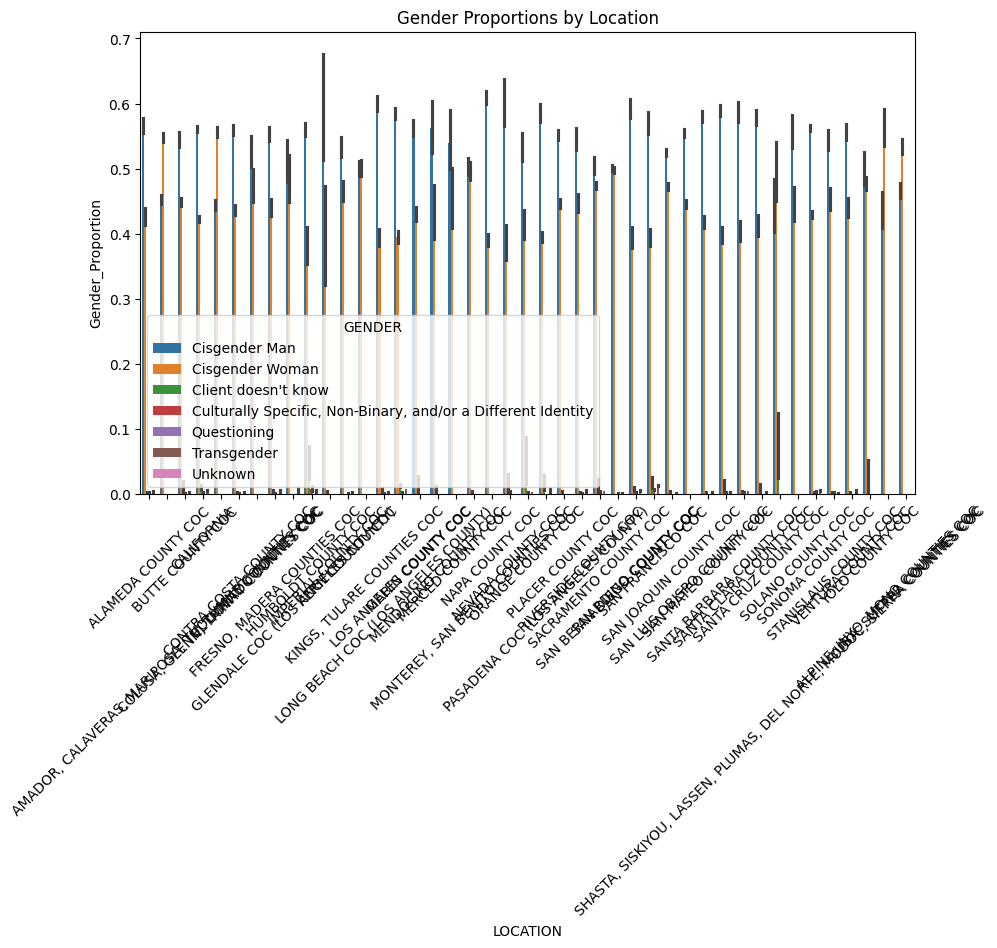

In [30]:
# Gender Proportions
plt.figure(figsize=(10, 6))
sns.barplot(x="LOCATION", y="Gender_Proportion", hue="GENDER", data=gender_counts)
plt.title('Gender Proportions by Location')
plt.xticks(rotation=45)
plt.show()

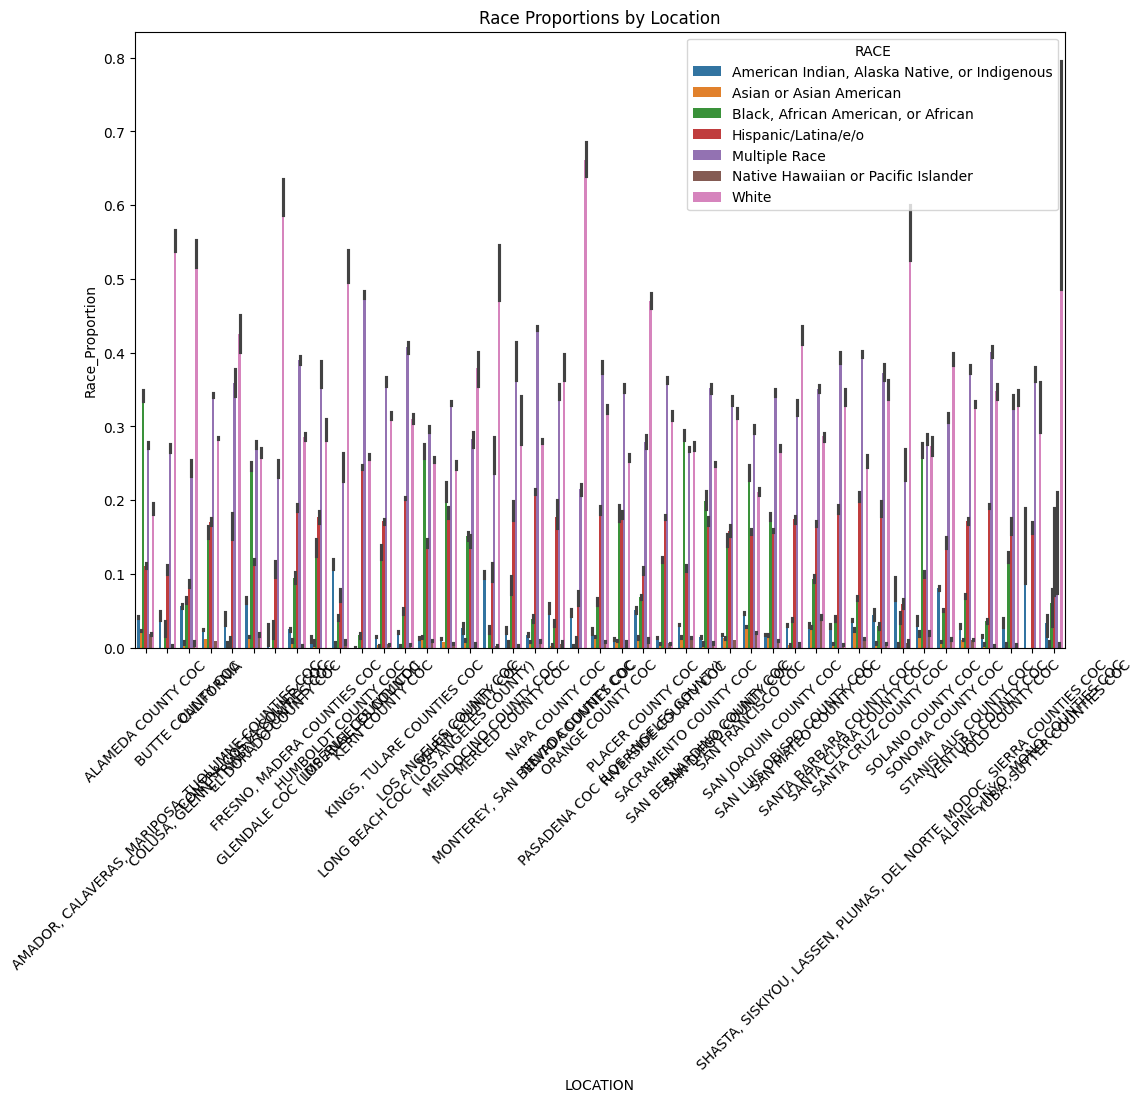

In [31]:
#Race Proportions:
plt.figure(figsize=(12, 8))
sns.barplot(x="LOCATION", y="Race_Proportion", hue="RACE", data=race_counts)
plt.title('Race Proportions by Location')
plt.xticks(rotation=45)
plt.show()

3. Rate of Return to Homelessness
Calculate the change in the rate of return to homelessness over years or aggregate it by demographic. Assuming the treatedReturns.csv is loaded into treatedReturns DataFrame.

In [32]:
# Calculate the yearly change in rate for a specific demographic category
returns_df['Year'] = returns_df['Fiscal Year Start Date'].dt.year
returns_df.sort_values(by=['Specific Demographic', 'Year'], inplace=True)
returns_df['Rate_Change'] = returns_df.groupby(['Specific Demographic'])['Rate'].diff()

# For simplification, this calculates the yearly change. You might want to aggregate this data differently based on your analysis needs.

In [33]:
# Example: Displaying the rate change for "Black or African American"
black_or_african_american = returns_df[returns_df['Specific Demographic'] == 'Black or African American']
print(black_or_african_american[['Specific Demographic', 'Year', 'Rate', 'Rate_Change']])

          Specific Demographic  Year  Rate  Rate_Change
2    Black or African American  2016  0.00          NaN
28   Black or African American  2016  0.28         0.28
54   Black or African American  2016  0.05        -0.23
80   Black or African American  2016  0.18         0.13
106  Black or African American  2016  0.15        -0.03
132  Black or African American  2017  0.00        -0.15
158  Black or African American  2017  0.17         0.17
184  Black or African American  2017  0.16        -0.01
210  Black or African American  2017  0.42         0.26
236  Black or African American  2017  0.22        -0.20
262  Black or African American  2018  0.33         0.11
288  Black or African American  2018  0.15        -0.18
314  Black or African American  2018  0.14        -0.01
340  Black or African American  2018  0.43         0.29
366  Black or African American  2018  0.17        -0.26


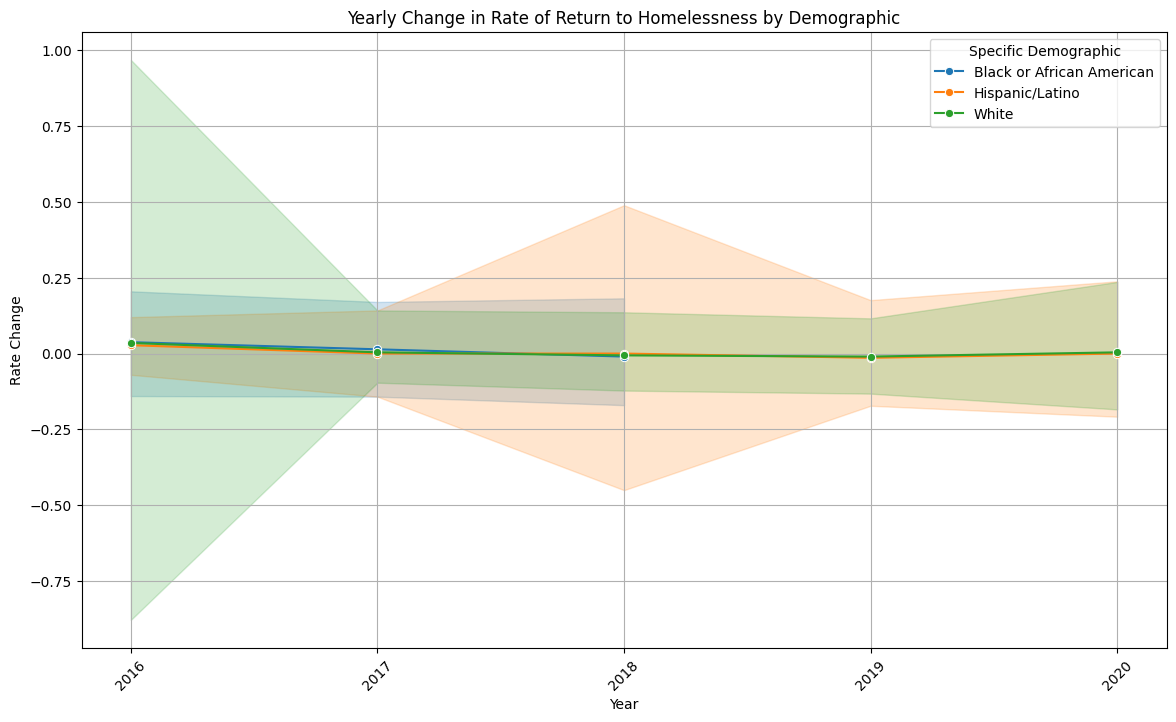

In [35]:
# Assuming you're interested in a few specific demographics
demographics_of_interest = ['Black or African American', 'White', 'Hispanic/Latino']
filtered_data = returns_df[returns_df['Specific Demographic'].isin(demographics_of_interest)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_data, x='Year', y='Rate_Change', hue='Specific Demographic', marker='o')
plt.title('Yearly Change in Rate of Return to Homelessness by Demographic')
plt.xlabel('Year')
plt.ylabel('Rate Change')
plt.xticks(filtered_data['Year'].unique(), rotation=45)  # Ensure x-ticks are properly labeled
plt.grid(True)
plt.show()


In [ ]:
Normalization of consolidated_data

In [20]:
# Selecting numerical features for normalization
features_to_normalize = ['EXPERIENCING_HOMELESSNESS_CNT_x', 'EXPERIENCING_HOMELESSNESS_CNT_y', 'EXPERIENCING_HOMELESSNESS_CNT']

# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Fitting the scaler to the features and transforming them
consolidated_df[features_to_normalize] = scaler.fit_transform(consolidated_df[features_to_normalize])

# Checking the result
print(consolidated_df[features_to_normalize].head())


   EXPERIENCING_HOMELESSNESS_CNT_x  EXPERIENCING_HOMELESSNESS_CNT_y  \
0                          0.01195                         0.020489   
1                          0.01195                         0.020489   
2                          0.01195                         0.020489   
3                          0.01195                         0.020489   
4                          0.01195                         0.020489   

   EXPERIENCING_HOMELESSNESS_CNT  
0                       0.000514  
1                       0.003552  
2                       0.001469  
3                       0.000965  
4                       0.031291  


Normalization of treatedReturns


In [43]:
# Selecting features for normalization
features_to_normalize_returns = ['Rate', 'Rate_Change']

# Note: Ensure that 'Rate_Change' doesn't have NaN values before normalization or decide how to handle them (e.g., fill with zeros)
returns_df['Rate_Change'] = returns_df['Rate_Change'].fillna(0)

# Initializing the MinMaxScaler
scaler_returns = MinMaxScaler()

# Fitting the scaler to the features and transforming them
returns_df[features_to_normalize_returns] = scaler_returns.fit_transform(returns_df[features_to_normalize_returns])

# Checking the result
print(returns_df[features_to_normalize_returns].head())

         Rate  Rate_Change
19   0.000000     0.478927
45   0.129496     0.547893
71   0.050360     0.436782
97   0.000000     0.452107
123  0.093525     0.528736


Save the normalized data into csv formats

In [44]:
returns_df.to_csv(path_or_buf="./data/normalized/treatedNReturns.csv")
consolidated_df.to_csv(path_or_buf="./data/normalized/consolidatedNData.csv")

Simplifying dataset

In [21]:
consolidated_df.columns

Index(['CALENDAR_YEAR', 'LOCATION_ID_x', 'LOCATION', 'AGE_GROUP_PUBLIC',
       'EXPERIENCING_HOMELESSNESS_CNT_x', 'LOCATION_ID_y', 'GENDER',
       'EXPERIENCING_HOMELESSNESS_CNT_y', 'LOCATION_ID', 'RACE',
       'RACE ALONE OR IN COMBINATION', 'EXPERIENCING_HOMELESSNESS_CNT',
       'Children_Flag', 'Adult_Flag', 'Elder_Flag'],
      dtype='object')

In [22]:
#drop unnecessary columns
consolidated_data_simplified = consolidated_df.drop(['LOCATION_ID_x', 'LOCATION_ID_y', 'LOCATION_ID', 'LOCATION',], axis=1)


In [23]:
consolidated_data_simplified.groupby('CALENDAR_YEAR')

In [26]:
consolidated_data_simplified['GENDER'].unique()

array(['Man', 'Woman', 'Unknown', 'Non-Binary', 'Transgender'],
      dtype=object)

In [25]:
consolidated_data_simplified['GENDER'] = consolidated_data_simplified['GENDER'].replace({'Cisgender Man': 'Man'})
consolidated_data_simplified['GENDER'] = consolidated_data_simplified['GENDER'].replace({'Cisgender Woman': 'Woman'})
consolidated_data_simplified['GENDER'] = consolidated_data_simplified['GENDER'].replace({'Culturally Specific, Non-Binary, and/or a Different Identity': 'Non-Binary'})

consolidated_data_simplified['GENDER'] = consolidated_data_simplified['GENDER'].replace({"Client doesn't know": 'Unknown'})
consolidated_data_simplified['GENDER'] = consolidated_data_simplified['GENDER'].replace({'Questioning': 'Unknown'})

In [8]:
consolidated_data_simplified['RACE'].unique()

array(['American Indian, Alaska Native, or Indigenous',
       'Asian or Asian American', 'Black, African American, or African',
       'Hispanic/Latina/e/o', 'Native Hawaiian or Pacific Islander',
       'White', 'Multiple Race'], dtype=object)

In [10]:
consolidated_data_simplified['RACE ALONE OR IN COMBINATION'].unique()

array(['Race Alone', 'Race Combination'], dtype=object)

In [30]:
consolidated_data_simplified['EXPERIENCING_HOMELESSNESS_CNT_x'] = consolidated_data_simplified.groupby('AGE_GROUP_PUBLIC')['EXPERIENCING_HOMELESSNESS_CNT_x'].transform(lambda x: x.fillna(x.median()))
consolidated_data_simplified['EXPERIENCING_HOMELESSNESS_CNT_y'] = consolidated_data_simplified.groupby('GENDER')['EXPERIENCING_HOMELESSNESS_CNT_y'].transform(lambda x: x.fillna(x.median()))
consolidated_data_simplified['EXPERIENCING_HOMELESSNESS_CNT'] = consolidated_data_simplified.groupby('RACE')['EXPERIENCING_HOMELESSNESS_CNT'].fillna(lambda x: x.fillna(x.median()))

/var/folders/tp/3wd6yzls5mn3qq9p_wh49y5r0000gn/T/ipykernel_31630/1919315992.py:3: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  consolidated_data_simplified['EXPERIENCING_HOMELESSNESS_CNT'] = consolidated_data_simplified.groupby('RACE')['EXPERIENCING_HOMELESSNESS_CNT'].fillna(lambda x: x.fillna(x.median()))


In [57]:
consolidated_data_simplified.notnull().sum()

CALENDAR_YEAR                      161308
AGE_GROUP_PUBLIC                   161308
EXPERIENCING_HOMELESSNESS_CNT_x    157374
GENDER                             161308
EXPERIENCING_HOMELESSNESS_CNT_y    100100
RACE                               161308
RACE ALONE OR IN COMBINATION       161308
EXPERIENCING_HOMELESSNESS_CNT      143032
Children_Flag                      161308
Adult_Flag                         161308
Elder_Flag                         161308
dtype: int64

In [31]:
consolidated_data_simplified.isnull().sum()

CALENDAR_YEAR                      0
AGE_GROUP_PUBLIC                   0
EXPERIENCING_HOMELESSNESS_CNT_x    0
GENDER                             0
EXPERIENCING_HOMELESSNESS_CNT_y    0
RACE                               0
RACE ALONE OR IN COMBINATION       0
EXPERIENCING_HOMELESSNESS_CNT      0
Children_Flag                      0
Adult_Flag                         0
Elder_Flag                         0
dtype: int64

In [54]:
consolidated_data_simplified.to_csv(path_or_buf="./data/normalized/consolidatedNDataSimplified.csv")

Kaggle Data Processing

In [37]:
# Load your dataset
df = pd.read_csv('./data/kaggle/homeless_prep.csv')

In [27]:
df.dtypes

CLIENT_KEY          int64
AGE                 int64
GENDER             object
VETERAN            object
INCOME            float64
NIGHTS            float64
substanceabuse      int64
completed           int64
probation           int64
assistancetype     object
required            int64
dtype: object

Data Cleaning

In [40]:
# Check for and drop duplicate rows
df = df.drop_duplicates()

# Handle missing values
df['NIGHTS'] = df['NIGHTS'].fillna(df['NIGHTS'].median())

# Convert boolean features to 0s and 1s
df['VETERAN'] = df['VETERAN'].apply(lambda x: 1 if x == 'Yes' else 0)

In [29]:
df.head()

,CLIENT_KEY,AGE,GENDER,VETERAN,INCOME,NIGHTS,substanceabuse,completed,probation,assistancetype,required
0,256172,20,Female,0,0.0,152.0,0,0,1,tempassistance,1
1,221079,20,Female,0,740.0,229.0,0,1,0,tempassistance,1
2,243074,21,Female,0,0.0,105.0,1,1,0,tempassistance,1
3,129974,21,Female,0,0.0,371.0,1,1,0,tempassistance,1
4,226596,22,Female,0,0.0,169.0,0,0,0,tempassistance,1


In [30]:
# Check for missing values
print(df.isnull().sum())

CLIENT_KEY        0
AGE               0
GENDER            0
VETERAN           0
INCOME            0
NIGHTS            0
substanceabuse    0
completed         0
probation         0
assistancetype    0
required          0
dtype: int64


Feature Extraction

In [41]:
# Create income to nights ratio to see if the amount of income affects the length of stay
df['INCOME_PER_NIGHT'] = df['INCOME'] / df['NIGHTS']

# Categorizing age into groups might help the model pick up on trends within specific age groups
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=[0, 18, 25, 40, 55, 70, 100], labels=['0-18', '19-25', '26-40', '41-55', '56-70', '71+'])


In [32]:
df.head()

,CLIENT_KEY,AGE,GENDER,VETERAN,INCOME,NIGHTS,substanceabuse,completed,probation,assistancetype,required,INCOME_PER_NIGHT,AGE_GROUP
0,256172,20,Female,0,0.0,152.0,0,0,1,tempassistance,1,0.000000,19-25
1,221079,20,Female,0,740.0,229.0,0,1,0,tempassistance,1,3.231441,19-25
2,243074,21,Female,0,0.0,105.0,1,1,0,tempassistance,1,0.000000,19-25
3,129974,21,Female,0,0.0,371.0,1,1,0,tempassistance,1,0.000000,19-25
4,226596,22,Female,0,0.0,169.0,0,0,0,tempassistance,1,0.000000,19-25


In [17]:
# First, print or inspect the column names to ensure they match your expectations
print(df.columns)

# # Ensure the column names you pass to pd.get_dummies match exactly
# corrected_columns = ['GENDER', 'VETERAN', 'assistancetype', 'AGE_GROUP']  # Adjusted to match your sample data

# # One-hot encoding for categorical variables such as GENDER, VETERAN, SUBSTANCEABUSE, COMPLETED, PROBATION, ASSISTANCETYPE, REQUIRED
# df = pd.get_dummies(df, columns=corrected_columns, drop_first=True)

Index(['CLIENT_KEY', 'AGE', 'GENDER', 'VETERAN', 'INCOME', 'NIGHTS',
       'substanceabuse', 'completed', 'probation', 'assistancetype',
       'required', 'INCOME_PER_NIGHT', 'AGE_GROUP'],
      dtype='object')


Synthesizing Non-homeless Data

Assumptions for Non-homeless Data Points:
- Higher Income Levels: Individuals not at risk of homelessness are likely to have higher income levels.
- Stable Housing: Reflected indirectly through fewer nights spent in shelters. We can simulate this by assigning lower values to the NIGHTS feature for not at risk individuals.
- Substance Abuse and Probation: Lower incidences of substance abuse and probation statuses could be associated with the not at risk group.
- Assistance Required: Lower likelihood of requiring temporary assistance or other shelter services.

In [38]:
df['AT_RISK_OF_HOMELESSNESS'] = 1  # Marking original samples as at risk

In [39]:
# Let's assume we want to add an equal number of not at risk individuals
num_samples = len(df)

# Generate synthetic data
np.random.seed(42)  # Ensure reproducibility

# Assuming certain ranges based on assumptions for non-homeless individuals
age_distribution = np.random.randint(18, 70, num_samples)
income_distribution = np.random.choice([i for i in range(5000, 50001, 5000)], num_samples)
nights_distribution = np.random.choice([i for i in range(0, 5)], num_samples)  # Assuming fewer nights in shelters
substance_abuse_distribution = np.random.choice([0, 1], num_samples, p=[0.9, 0.1])  # Lower probability of substance abuse
completed_distribution = np.random.choice([0, 1], num_samples, p=[0.5, 0.5])
probation_distribution = np.random.choice([0, 1], num_samples, p=[0.95, 0.05])  # Lower probation rates
assistance_type_distribution = np.random.choice(['tempassistance', 'permassistance', 'noassistance'], num_samples, p=[0.2, 0.1, 0.7])
required_distribution = np.random.choice([0, 1], num_samples, p=[0.8, 0.2])  # Lower likelihood of requiring assistance
gender_distribution = np.random.choice(['Male', 'Female'], num_samples, p=[0.50, 0.50])  # Assuming a distribution
veteran_distribution = np.random.choice([0, 1], num_samples, p=[0.9, 0.1])  # Assuming fewer veterans

# Create a DataFrame
synthetic_df = pd.DataFrame({
    'AGE': age_distribution,
    'INCOME': income_distribution,
    'NIGHTS': nights_distribution,
    'substanceabuse': substance_abuse_distribution,
    'completed': completed_distribution,
    'probation': probation_distribution,
    'assistancetype': assistance_type_distribution,
    'required': required_distribution,
    'GENDER': gender_distribution,
    'VETERAN': veteran_distribution,
    'AT_RISK_OF_HOMELESSNESS': 0  # Marking these samples as not at risk
})

# Combine the original and synthetic DataFrames
augmented_df = pd.concat([df, synthetic_df], ignore_index=True)


In [35]:
augmented_df.head()

,CLIENT_KEY,AGE,GENDER,VETERAN,INCOME,NIGHTS,substanceabuse,completed,probation,assistancetype,required,INCOME_PER_NIGHT,AGE_GROUP,AT_RISK_OF_HOMELESSNESS
0,256172.0,20,Female,0,0.0,152.0,0,0,1,tempassistance,1,0.000000,19-25,1
1,221079.0,20,Female,0,740.0,229.0,0,1,0,tempassistance,1,3.231441,19-25,1
2,243074.0,21,Female,0,0.0,105.0,1,1,0,tempassistance,1,0.000000,19-25,1
3,129974.0,21,Female,0,0.0,371.0,1,1,0,tempassistance,1,0.000000,19-25,1
4,226596.0,22,Female,0,0.0,169.0,0,0,0,tempassistance,1,0.000000,19-25,1


In [43]:
df = augmented_df 
df['INCOME_PER_NIGHT'] = df['INCOME'] / df['NIGHTS']

# Categorizing age into groups might help the model pick up on trends within specific age groups
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=[0, 18, 25, 40, 55, 70, 100], labels=['0-18', '19-25', '26-40', '41-55', '56-70', '71+'])

In [45]:
df = df.round(2)

In [46]:
df.to_csv(path_or_buf="./data/treated/augmentedData.csv")

Bigger synthesized dataset

In [47]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 5000

# Continuous features
age = np.random.randint(18, 70, n_samples)  # Ages 18 to 69
income = np.random.choice([0] + list(range(500, 50001, 500)), n_samples, p=[0.2] + [0.8 / 100] * 100)  # Including zero income
nights = np.random.randint(1, 365, n_samples)  # Number of nights, max 1 year

# Categorical features
gender = np.random.choice(['Female', 'Male', 'Other'], n_samples, p=[0.49, 0.49, 0.02])
veteran = np.random.choice(['Yes', 'No'], n_samples, p=[0.1, 0.9])  # Assuming 10% are veterans
assistancetype = np.random.choice(['tempassistance', 'permassistance', 'noassistance'], n_samples, p=[0.4, 0.1, 0.5])

# Binary features (yes/no or similar, represented as 0/1)
substanceabuse = np.random.binomial(1, 0.3, n_samples)  # Assuming 30% have substance abuse issues
completed = np.random.binomial(1, 0.5, n_samples)  # 50% completion rate for a program or education
probation = np.random.binomial(1, 0.2, n_samples)  # 20% on probation
required = np.random.binomial(1, 0.7, n_samples)  # 70% required to seek assistance

# Derived feature
income_per_night = np.round(income / np.maximum(nights, 1), 2)  # Avoid division by zero

# Target variable: AT_RISK_OF_HOMELESSNESS
# For simplicity, let's assume the risk increases with certain conditions but ensure some randomness
risk_factors = (income < 10000) & (nights < 30) & (substanceabuse == 1) | (veteran == 'Yes')
at_risk_of_homelessness = np.random.binomial(1, 0.1 + 0.4 * risk_factors)  # Base risk plus increased with factors

# Age group (derived categorically from age)
bins = [17, 25, 40, 55, 70]
labels = ['18-25', '26-40', '41-55', '56-70']
age_group = pd.cut(age, bins=bins, labels=labels)

# Creating the DataFrame
df = pd.DataFrame({
    'AGE': age,
    'GENDER': gender,
    'VETERAN': veteran,
    'INCOME': income,
    'NIGHTS': nights,
    'substanceabuse': substanceabuse,
    'completed': completed,
    'probation': probation,
    'assistancetype': assistancetype,
    'required': required,
    'AT_RISK_OF_HOMELESSNESS': at_risk_of_homelessness,
    'INCOME_PER_NIGHT': income_per_night,
    'AGE_GROUP': age_group
})

print(df.head())


   AGE  GENDER VETERAN  INCOME  NIGHTS  substanceabuse  completed  probation  \
0   56  Female      No   47500     208               1          0          0   
1   69    Male      No   12500     254               0          1          1   
2   46  Female      No   40000     221               0          1          1   
3   32    Male      No       0     262               1          0          0   
4   60  Female      No   30000     331               0          1          0   

   assistancetype  required  AT_RISK_OF_HOMELESSNESS  INCOME_PER_NIGHT  \
0    noassistance         1                        0            228.37   
1  tempassistance         0                        0             49.21   
2  permassistance         0                        0            181.00   
3    noassistance         0                        0              0.00   
4  tempassistance         1                        0             90.63   

  AGE_GROUP  
0     56-70  
1     56-70  
2     41-55  
3     26-40  
4   

In [ ]:
df.to_csv(path_or_buf="./data/treated/biggerAugmentedData.csv")